<a href="https://colab.research.google.com/github/xcellentbird/playground/blob/main/logistic_regression_only_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numpy만으로 구현하는 머신러닝 알고리즘 (from scratch)

- 이 노트북은 오직 `numpy`만 사용하여 핵심 알고리즘을 직접 구현합니다.
- 각 클래스는 입력 파라미터를 설명하는 docstring과, 학습을 돕는 주석을 포함합니다.
- 구현 목록
  - LinearRegression (회귀)
  - Softmax LogisticRegression (다중분류)
  - MultiLabel LogisticRegression (멀티라벨 분류)

학습 목적: 수식과 구현이 1:1로 연결되도록, 가능한 한 단순하고 명확한 구조를 유지합니다.


In [1]:
import numpy as np

# ===== 공통 유틸리티 =====

def set_seed(seed: int | None = 42) -> np.random.Generator:
    """시드 고정을 위한 유틸. Numpy Generator 반환.

    Parameters
    ----------
    seed : int | None
        무작위 시드. None이면 비결정적.
    """
    return np.random.default_rng(seed)


def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2, shuffle: bool = True,
                     random_state: int | None = 42) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """간단한 학습/검증 분할 (Stratify 미지원)"""
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng = set_seed(random_state)
        rng.shuffle(idx)
    test_n = int(np.floor(n * test_size))
    test_idx = idx[:test_n]
    train_idx = idx[test_n:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


def standardize(X: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """특성 표준화: (X - mean) / std. 분산 0 보호 포함."""
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True)
    std_safe = np.where(std < 1e-12, 1.0, std)
    return (X - mean) / std_safe, mean, std_safe


def apply_standardize(X: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    """학습 시 구한 mean/std로 입력 X를 변환."""
    return (X - mean) / std


def one_hot(y: np.ndarray, num_classes: int | None = None) -> np.ndarray:
    """정수 레이블 y를 one-hot으로 변환.

    y는 (n,) 또는 (n, 1) 형태.
    """
    y = y.reshape(-1)
    if num_classes is None:
        num_classes = int(y.max()) + 1
    oh = np.zeros((y.shape[0], num_classes), dtype=float)
    oh[np.arange(y.shape[0]), y.astype(int)] = 1.0
    return oh


def sigmoid(z: np.ndarray) -> np.ndarray:
    # 수치 안정성을 위한 구현
    z_clip = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clip))


def softmax(z: np.ndarray) -> np.ndarray:
    # row-wise 안정 softmax
    z_max = np.max(z, axis=1, keepdims=True)
    exp = np.exp(z - z_max)
    return exp / np.sum(exp, axis=1, keepdims=True)


def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean(y_true == y_pred))


def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean((y_true - y_pred) ** 2))


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(mse(y_true, y_pred)))


def add_bias_column(X: np.ndarray) -> np.ndarray:
    return np.hstack([X, np.ones((X.shape[0], 1))])



In [2]:
import numpy as np

# ===== 데이터 생성 유틸 =====

def make_blobs(n_samples: int = 600, centers: int = 3, n_features: int = 2, cluster_std: float = 1.0,
                center_box: tuple[float, float] = (-5.0, 5.0), random_state: int | None = 42) -> tuple[np.ndarray, np.ndarray]:
    """Scikit-learn의 make_blobs 유사 함수 (간단 버전)

    Parameters
    ----------
    n_samples : int
        샘플 수
    centers : int
        군집(클래스) 수
    n_features : int
        특성 차원
    cluster_std : float
        군집 표준편차 (동일 가정)
    center_box : tuple
        군집 중심을 균일분포로 뿌릴 범위
    random_state : int | None
        시드
    """
    rng = np.random.default_rng(random_state)
    centers_coords = rng.uniform(low=center_box[0], high=center_box[1], size=(centers, n_features))
    samples_per_center = [n_samples // centers] * centers
    for i in range(n_samples % centers):
        samples_per_center[i] += 1
    X_list = []
    y_list = []
    for k, n_k in enumerate(samples_per_center):
        X_k = centers_coords[k] + rng.normal(0.0, cluster_std, size=(n_k, n_features))
        y_k = np.full(n_k, k)
        X_list.append(X_k)
        y_list.append(y_k)
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y


def make_circles(n_samples: int = 600, noise: float = 0.05, factor: float = 0.5, random_state: int | None = 42) -> tuple[np.ndarray, np.ndarray]:
    """Scikit-learn의 make_circles 유사 함수 (2D 이중원형 데이터)

    Parameters
    ----------
    n_samples : int
        전체 샘플 수 (짝수 권장)
    noise : float
        반지름에 대한 가우시안 노이즈 스케일
    factor : float
        내부 원의 반지름 비율 (0~1)
    random_state : int | None
        시드
    """
    rng = np.random.default_rng(random_state)
    n_outer = n_samples // 2
    n_inner = n_samples - n_outer
    angles_outer = rng.uniform(0, 2 * np.pi, size=n_outer)
    angles_inner = rng.uniform(0, 2 * np.pi, size=n_inner)
    outer = np.stack([np.cos(angles_outer), np.sin(angles_outer)], axis=1)
    inner = factor * np.stack([np.cos(angles_inner), np.sin(angles_inner)], axis=1)
    X = np.vstack([outer, inner])
    if noise > 0:
        X += rng.normal(0.0, noise, size=X.shape)
    y = np.concatenate([np.zeros(n_outer, dtype=int), np.ones(n_inner, dtype=int)])
    return X, y



In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 시각화 유틸 =====

def plot_decision_boundary_2d(predict_fn, X: np.ndarray, y: np.ndarray, title: str = "Decision boundary",
                              h: float = 0.02, cmap: str = "viridis") -> None:
    """2D 데이터의 결정 경계 시각화.

    Parameters
    ----------
    predict_fn : callable
        입력 (n, 2) -> 정수 클래스 라벨 (n,)을 반환하는 함수
    X : np.ndarray
        입력 데이터 (n, 2)
    y : np.ndarray
        정수 라벨 (n,)
    title : str
        그래프 제목
    h : float
        그리드 해상도
    cmap : str
        컬러맵 이름
    """
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_fn(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=cmap, edgecolor="k")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np

class LinearRegression:
    """평균제곱오차(MSE)를 최소화하는 선형회귀 (정규화 옵션 포함)

    Parameters
    ----------
    lr : float
        학습률 (경사하강법)
    n_iters : int
        반복 횟수
    l2 : float
        L2 정규화 강도 (릿지). 0이면 비정규화.
    fit_intercept : bool
        절편 사용 여부. True면 내부적으로 바이어스 컬럼을 추가.
    random_state : int | None
        가중치 초기화 시드
    """

    def __init__(self, lr: float = 0.1, n_iters: int = 1000, l2: float = 0.0, fit_intercept: bool = True,
                 random_state: int | None = 42):
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.w: np.ndarray | None = None  # (d,) or (d+1,) if bias

    def _prepare_X(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            return add_bias_column(X)
        return X

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        Xb = self._prepare_X(X)
        n, d = Xb.shape
        rng = np.random.default_rng(self.random_state)
        # 작은 난수로 초기화 (대칭 깨기)
        self.w = rng.normal(0.0, 1e-2, size=d)
        y = y.reshape(-1)

        for _ in range(self.n_iters):
            # 예측
            y_pred = Xb @ self.w
            # 잔차
            error = y_pred - y
            # 그라디언트 (L2 포함): (1/n) X^T (Xw - y) + l2 * w
            grad = (Xb.T @ error) / n
            print(grad)
            if self.l2 > 0:
                # 바이어스는 정규화 제외
                if self.fit_intercept:
                    grad[:-1] += self.l2 * self.w[:-1]
                else:
                    grad += self.l2 * self.w
            # 파라미터 업데이트
            self.w -= self.lr * grad
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert self.w is not None, "Model is not fitted"
        Xb = self._prepare_X(X)
        return Xb @ self.w



In [5]:
# ===== LinearRegression 데모 =====
# y = 3x1 - 2x2 + 5 + noise 형태의 2D 선형 데이터 생성
rng = set_seed(0)
X_lr = rng.normal(0, 1, size=(500, 2))
true_w = np.array([3.0, -2.0])
true_b = 5.0
noise = rng.normal(0, 0.5, size=(500,))
y_lr = X_lr @ true_w + true_b + noise

X_tr_lr, X_te_lr, y_tr_lr, y_te_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=0)

lr = LinearRegression(lr=0.1, n_iters=2000, l2=1e-3, fit_intercept=True, random_state=0)
lr.fit(X_tr_lr, y_tr_lr)

print("학습된 가중치(가까울수록 좋음):", lr.w)
print("RMSE(train)", rmse(y_tr_lr, lr.predict(X_tr_lr)))
print("RMSE(test) ", rmse(y_te_lr, lr.predict(X_te_lr)))


[-2.50709607  1.84598233 -4.84671448]
[-2.30186563  1.67886961 -4.37565891]
[-2.11310446  1.52687413 -3.95057793]
[-1.93952978  1.38863132 -3.56696645]
[-1.77995438  1.26289948 -3.2207625 ]
[-1.63327991  1.14854872 -2.90830352]
[-1.49849077  1.04455096 -2.62628694]
[-1.37464823  0.94997076 -2.37173464]
[-1.26088498  0.86395699 -2.141961  ]
[-1.15639998  0.78573527 -1.93454403]
[-1.06045374  0.71460107 -1.74729942]
[-0.97236376  0.6499134  -1.57825711]
[-0.8915004   0.59108913 -1.42564022]
[-0.81728299  0.53759775 -1.287846  ]
[-0.74917614  0.48895666 -1.16342874]
[-0.68668643  0.44472682 -1.0510843 ]
[-0.62935918  0.40450888 -0.94963619]
[-0.5767756   0.36793954 -0.85802306]
[-0.52855001  0.33468835 -0.77528735]
[-0.48432734  0.30445472 -0.70056511]
[-0.44378078  0.27696525 -0.63307682]
[-0.40660962  0.25197126 -0.57211912]
[-0.37253719  0.22924656 -0.51705731]
[-0.34130906  0.20858542 -0.46731863]
[-0.31269123  0.18980075 -0.42238622]
[-0.2864686   0.17272236 -0.38179359]
[-0.26244347

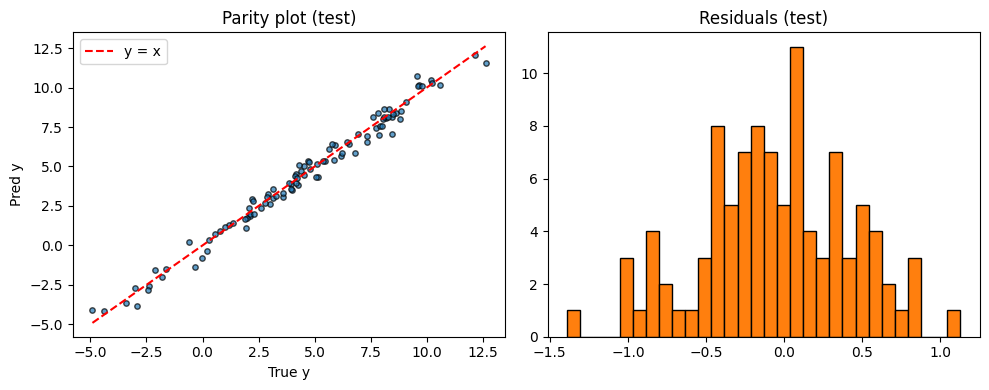

In [6]:
# ===== LinearRegression 시각화 =====
y_pred_te_lr = lr.predict(X_te_lr)

plt.figure(figsize=(10, 4))
# Parity plot
plt.subplot(1, 2, 1)
plt.scatter(y_te_lr, y_pred_te_lr, s=15, c="tab:blue", alpha=0.7, edgecolor="k")
_min, _max = float(min(y_te_lr.min(), y_pred_te_lr.min())), float(max(y_te_lr.max(), y_pred_te_lr.max()))
line = np.linspace(_min, _max, 100)
plt.plot(line, line, "r--", label="y = x")
plt.xlabel("True y")
plt.ylabel("Pred y")
plt.title("Parity plot (test)")
plt.legend()

# Residuals histogram
plt.subplot(1, 2, 2)
resid = y_pred_te_lr - y_te_lr
plt.hist(resid, bins=30, color="tab:orange", edgecolor="k")
plt.title("Residuals (test)")
plt.tight_layout()
plt.show()


In [7]:
import numpy as np

class SoftmaxLogisticRegression:
    """다중클래스 로지스틱 회귀 (소프트맥스)

    Parameters
    ----------
    lr : float
        학습률
    n_iters : int
        반복 횟수
    l2 : float
        L2 정규화 강도
    fit_intercept : bool
        절편 사용 여부
    random_state : int | None
        초기 가중치 시드
    """

    def __init__(self, lr: float = 0.1, n_iters: int = 1000, l2: float = 0.0, fit_intercept: bool = True,
                 random_state: int | None = 42):
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.W: np.ndarray | None = None  # (d, K) or (d+1, K)

    def _prepare_X(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            return add_bias_column(X)
        return X

    def fit(self, X: np.ndarray, y: np.ndarray) -> "SoftmaxLogisticRegression":
        """y는 (n,) 정수 라벨. 클래스 수는 자동 추정."""
        Xb = self._prepare_X(X)
        n, d = Xb.shape
        classes = int(np.max(y)) + 1
        rng = np.random.default_rng(self.random_state)
        self.W = rng.normal(0.0, 1e-2, size=(d, classes))
        y_oh = one_hot(y, classes)

        for _ in range(self.n_iters):
            logits = Xb @ self.W  # (n, K)
            probs = softmax(logits)  # (n, K)
            # 크로스엔트로피의 그라디언트: (1/n) X^T (p - y)
            grad = (Xb.T @ (probs - y_oh)) / n  # (d, K)
            if self.l2 > 0:
                if self.fit_intercept:
                    grad[:-1, :] += self.l2 * self.W[:-1, :]
                else:
                    grad += self.l2 * self.W
            self.W -= self.lr * grad
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        assert self.W is not None, "Model is not fitted"
        Xb = self._prepare_X(X)
        return softmax(Xb @ self.W)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)



정확도(train) 0.9642857142857143
정확도(test)  0.9388888888888889


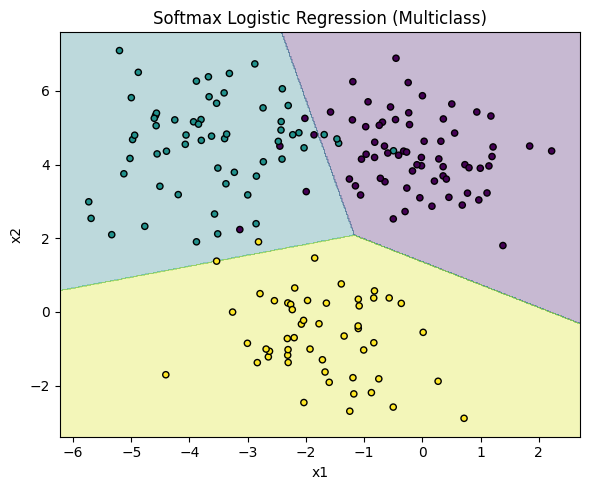

In [8]:
# ===== Softmax Multiclass 데모 + 시각화 =====
X_mc, y_mc = make_blobs(n_samples=600, centers=3, n_features=2, cluster_std=1.2, random_state=1)
X_tr, X_te, y_tr, y_te = train_test_split(X_mc, y_mc, test_size=0.3, random_state=1)

clf = SoftmaxLogisticRegression(lr=0.2, n_iters=2000, l2=1e-3, fit_intercept=True, random_state=1)
clf.fit(X_tr, y_tr)

print("정확도(train)", accuracy_score(y_tr, clf.predict(X_tr)))
print("정확도(test) ", accuracy_score(y_te, clf.predict(X_te)))

plot_decision_boundary_2d(lambda X: clf.predict(X), X_te, y_te, title="Softmax Logistic Regression (Multiclass)")


In [9]:
import numpy as np

class BinaryLogisticRegression:
    """이진 로지스틱 회귀 (시그모이드 + BCE)

    Parameters
    ----------
    lr : float
        학습률
    n_iters : int
        반복 횟수
    l2 : float
        L2 정규화 강도
    fit_intercept : bool
        절편 사용 여부
    random_state : int | None
        초기 가중치 시드
    """

    def __init__(self, lr: float = 0.1, n_iters: int = 1000, l2: float = 0.0, fit_intercept: bool = True,
                 random_state: int | None = 42):
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.w: np.ndarray | None = None

    def _prepare_X(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            return add_bias_column(X)
        return X

    def fit(self, X: np.ndarray, y: np.ndarray) -> "BinaryLogisticRegression":
        Xb = self._prepare_X(X)
        n, d = Xb.shape
        rng = np.random.default_rng(self.random_state)
        self.w = rng.normal(0.0, 1e-2, size=d)
        y = y.reshape(-1)

        for _ in range(self.n_iters):
            logits = Xb @ self.w
            p = sigmoid(logits)
            # BCE 그라디언트: (1/n) X^T (p - y)
            grad = (Xb.T @ (p - y)) / n
            if self.l2 > 0:
                if self.fit_intercept:
                    grad[:-1] += self.l2 * self.w[:-1]
                else:
                    grad += self.l2 * self.w
            self.w -= self.lr * grad
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        assert self.w is not None, "Model is not fitted"
        Xb = self._prepare_X(X)
        return sigmoid(Xb @ self.w)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        return (self.predict_proba(X) >= threshold).astype(int)



In [10]:
import numpy as np

class OneVsRestMultilabelLogistic:
    """One-vs-Rest(독립 이진 분류기들) 기반 멀티라벨 로지스틱 분류기

    Parameters
    ----------
    n_labels : int
        라벨(출력) 수
    lr : float
        학습률
    n_iters : int
        반복 횟수
    l2 : float
        L2 정규화 강도
    fit_intercept : bool
        절편 사용 여부
    random_state : int | None
        초기 가중치 시드
    """

    def __init__(self, n_labels: int, lr: float = 0.1, n_iters: int = 1000, l2: float = 0.0,
                 fit_intercept: bool = True, random_state: int | None = 42):
        self.n_labels = n_labels
        self.lr = lr
        self.n_iters = n_iters
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.clfs: list[BinaryLogisticRegression] = []

    def fit(self, X: np.ndarray, Y: np.ndarray) -> "OneVsRestMultilabelLogistic":
        """Y는 (n, L) 바이너리 멀티라벨 행렬"""
        self.clfs = []
        for j in range(self.n_labels):
            clf = BinaryLogisticRegression(lr=self.lr, n_iters=self.n_iters, l2=self.l2,
                                           fit_intercept=self.fit_intercept, random_state=self.random_state)
            clf.fit(X, Y[:, j])
            self.clfs.append(clf)
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        assert len(self.clfs) == self.n_labels, "Model is not fitted"
        probs = [clf.predict_proba(X) for clf in self.clfs]
        return np.stack(probs, axis=1)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        return (self.predict_proba(X) >= threshold).astype(int)



Exact match ratio: 0.9944444444444445
Label-wise accuracy: [0.99444444 1.         1.        ]


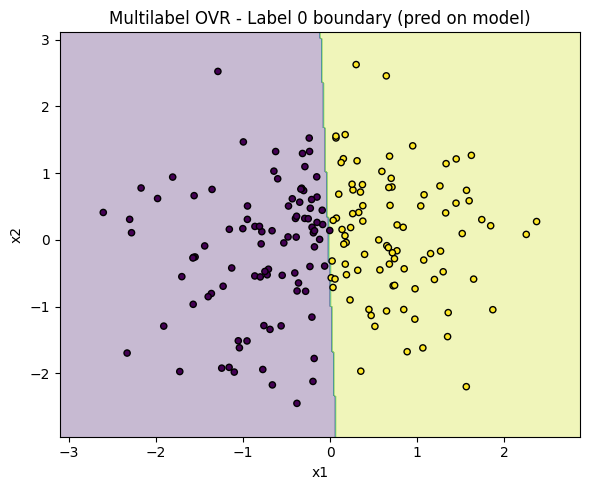

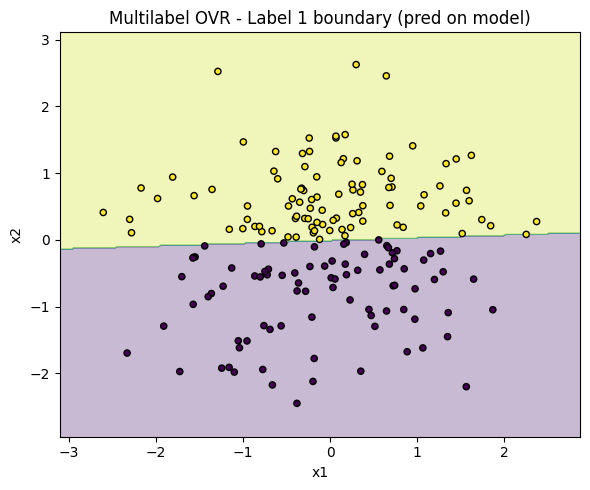

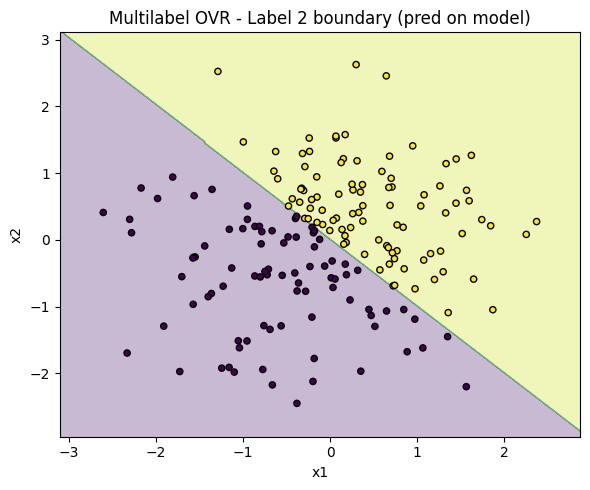

In [11]:
# ===== Multilabel 데모 + 시각화(각 라벨별 결정경계) =====
# 3개 라벨에 대해 독립적으로 이진 라벨을 만드는 합성 데이터
rng = set_seed(2)
X_ml = rng.normal(0, 1.0, size=(600, 2))
# 라벨 0: x1 > 0
# 라벨 1: x2 > 0
# 라벨 2: x1 + x2 > 0 (대각선 경계)
Y_ml = np.stack([(X_ml[:, 0] > 0).astype(int),
                 (X_ml[:, 1] > 0).astype(int),
                 ((X_ml[:, 0] + X_ml[:, 1]) > 0).astype(int)], axis=1)

X_tr, X_te, Y_tr, Y_te = train_test_split(X_ml, Y_ml, test_size=0.3, random_state=2)

ml_clf = OneVsRestMultilabelLogistic(n_labels=3, lr=0.2, n_iters=1500, l2=1e-3, fit_intercept=True, random_state=2)
ml_clf.fit(X_tr, Y_tr)

Y_pred = ml_clf.predict(X_te)
# 멀티라벨 정확도(정확히 일치 비율)와 라벨별 정확도
exact_match = np.mean(np.all(Y_pred == Y_te, axis=1))
label_acc = np.mean(Y_pred == Y_te, axis=0)
print("Exact match ratio:", exact_match)
print("Label-wise accuracy:", label_acc)

# 각 라벨별 결정경계 시각화
# predict_fn은 (n,2)->(n,) 정수 배열을 반환해야 합니다.
for j in range(3):
    plot_decision_boundary_2d(lambda X: ml_clf.predict(X)[:, j], X_te, Y_te[:, j],
                              title=f"Multilabel OVR - Label {j} boundary (pred on model)")